![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Annotation_Lab/Complete_ALab_Module_SparkNLP_JSL.ipynb)


# Spark NLP for Healthcare now has an easy to use module for interacting with Annotation Lab with minimal code.

## This tutorial provides instructions and code for the following operations:

### **Section 1: Exporting the ALAB project. <font color='blue'>ALAB Credentials are required.**</font>
1. Exporting through the Annotation Lab UI.
2. Exporting through a dedicated API.

### **Section 2: Generating training data for different models. <font color='blue'>No ALAB Credentials required - Only exported JSON is required.**</font>
3. Generating a csv/excel formatted file from the annotation JSON for training a classification model.
4. Generating a CoNLL formatted file from the annotation JSON for training an NER model.
5. Generating a csv/excel formatted file from the annotation JSON for training an assertion model.
6. Generating a csv/excel formatted file from the annotation JSON for training a Relation Extraction Model model.

### **Section 3: Generate pre-annotation JSON using a Spark NLP pipeline and saving as JSON. <font color='blue'>No ALAB Credentials required**</font>
7. Creating and applying pre-annotation pipeline.

### **Section 4: Interacting with the ALAB instance, and setting up projects. <font color='blue'>ALAB Credentials are required**</font>.
8. Getting list of all projects in the Annotation Lab instance.
9. Creating New Projects.
10. Deleting Projects.
11. Setting & editing configuration of projects.
12. Accessing/getting configuration of any existing project.
13. Upload tasks to a project.
14. Deleting tasks of a project.
15. Uploading Preannotations to a project. How to generate preannotations? Section 5.


In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import pandas as pd
import requests
import json
from zipfile import ZipFile
from io import BytesIO
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

# Section 1: Exporting the ALAB project - <font color='blue'>ALAB Credentials are required</font>

There are 2 options to access your Annotation Lab project JSON export:

1. Through the Annotation Lab UI
2. Through a dedicated API

### Set Credentials

In [ ]:
# import the module
from sparknlp_jsl.alab import AnnotationLab
alab = AnnotationLab()

username=''
password=''
client_secret=""
annotationlab_url=""

alab.set_credentials(
    
    # required: username
    username=username, 

    # required: password
    password=password, 

    # required: secret for you alab instance (every alab installation has a different secret)
    client_secret=client_secret, 

    # required: http(s) url for you annotation lab
    annotationlab_url=annotationlab_url
    
    )

## 1. Exporting through the Annotation Lab UI



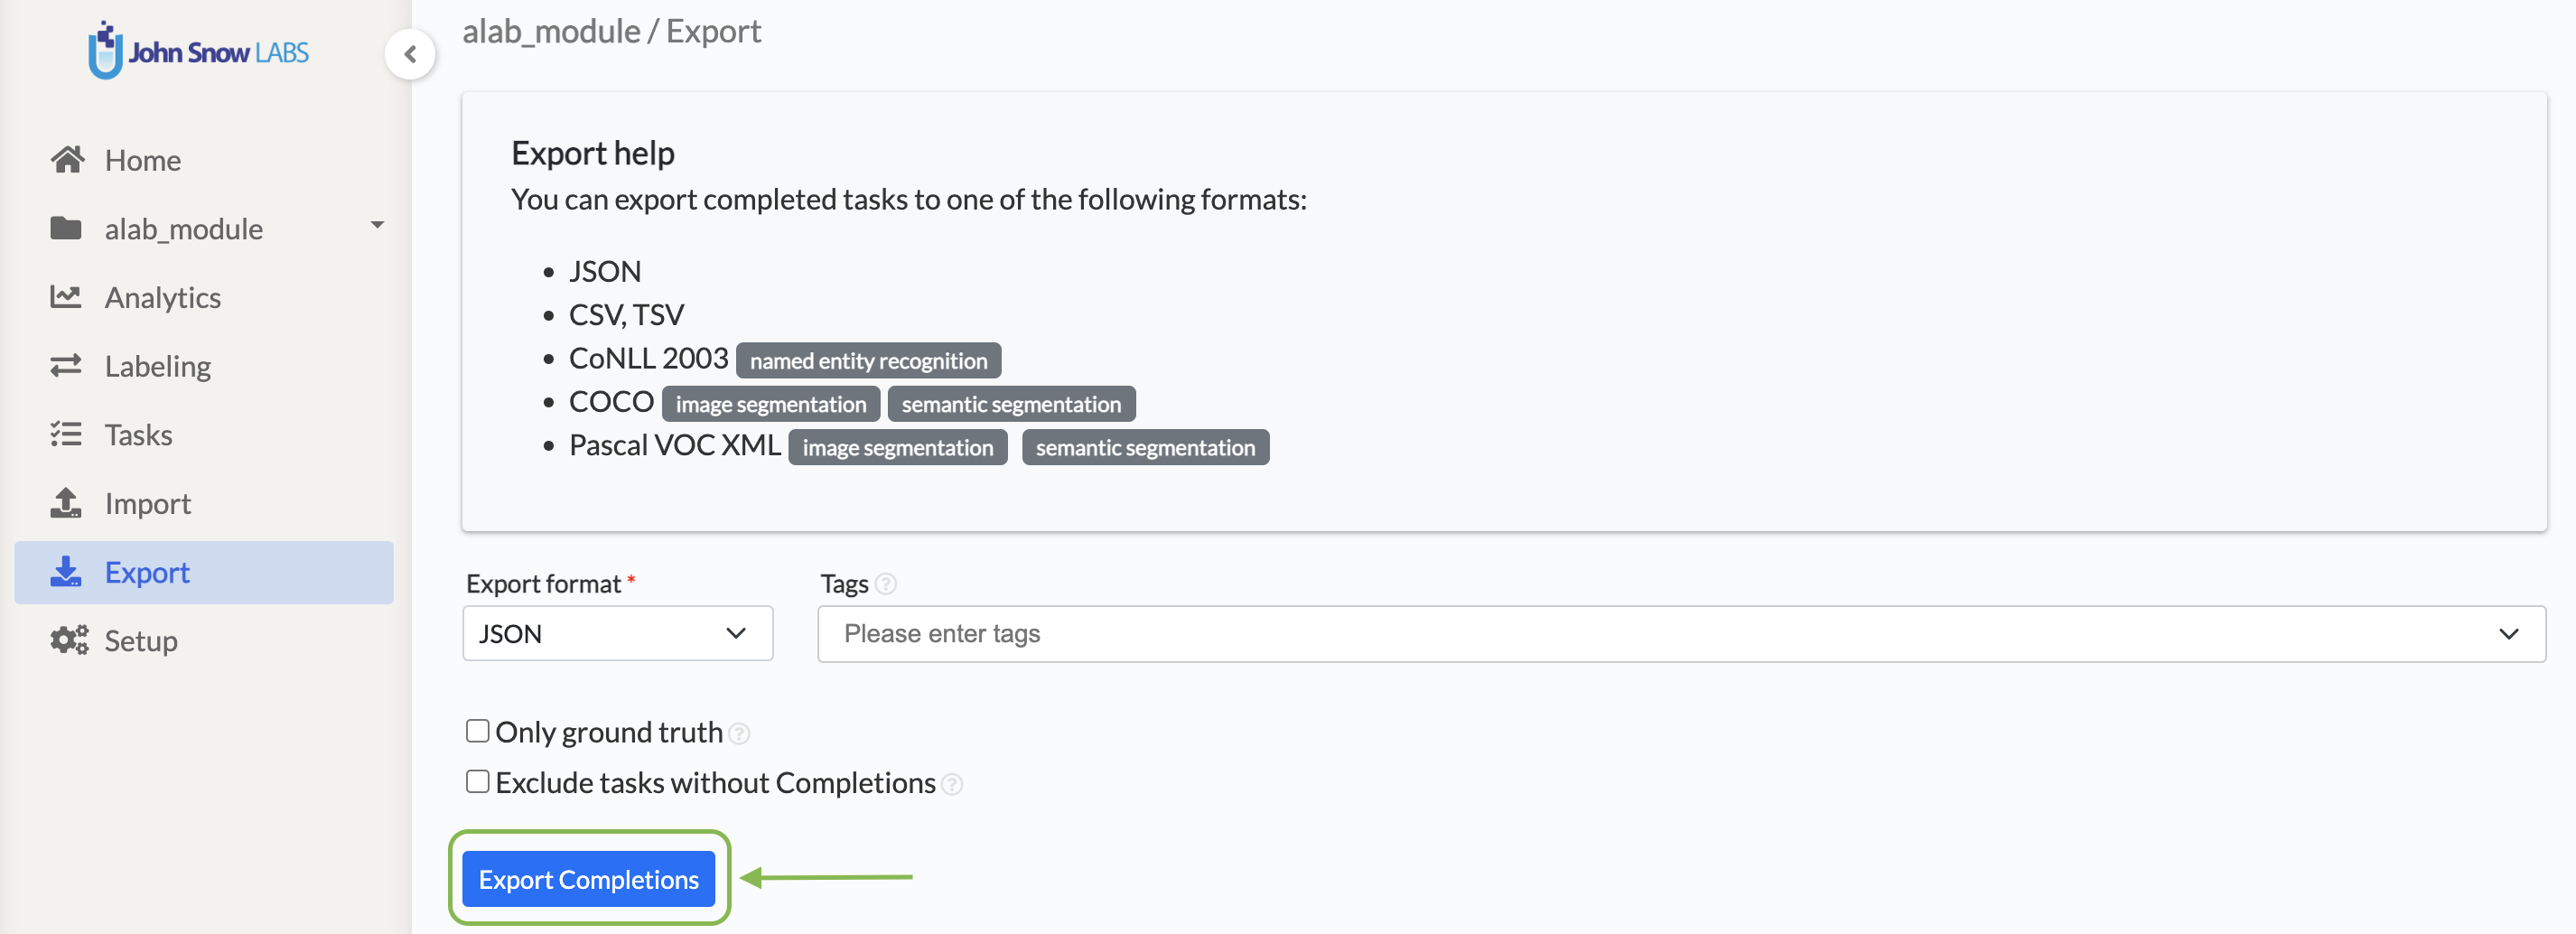

## 2. Exporting through a dedicated API

In [ ]:
alab.get_annotations(
    
    # required: official name given to project in Annotation Lab
    project_name='demo_100', 
                     
    # required: file name where to write the result as json
    output_name='project_export.json', 
    
    # optional: directory location where to save output json
    save_dir="."
    
    )

# Section 2: Using already exported JSON to generate training data - <font color='blue'>No Credentials Required</font>

### Start with an already exported JSON.

In [ ]:
# downloading demo json
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Annotation_Lab/data/alab_demo.json

## 3. Generate data for traing a classification model

In [ ]:
alab.get_classification_data(
    
    # required: path to Annotation Lab JSON export
    input_json_path='alab_demo.json',
    
    # optional: set to True to select ground truth completions, False to select latest completions, 
    # defaults to False
    ground_truth=True
    
    )

Processing 14 annotation(s).


,task_id,task_title,text,class
0,2,Note 2,The patient is a 5-month-old infant who presen...,[Female]
1,3,Note 3,The patient is a 21-day-old male here for 2 da...,[Male]
2,1,Note 1,On 18/08 patient declares she has a headache s...,[Female]


## 4. Converting the JSON export into a CoNLL format suitable for training an NER model

In [ ]:
alab.get_conll_data(
    
    # required: Spark session with spark-nlp-jsl jar
    spark=spark,

    # required: path to Annotation Lab JSON export
    input_json_path="alab_demo.json",

    # required: name of the CoNLL file to save
    output_name="conll_demo",

    # optional: path for CoNLL file saving directory, defaults to 'exported_conll'
    save_dir="exported_conll",

    # optional: set to True to select ground truth completions, False to select latest completions, 
    # defaults to False
    ground_truth=True,
    
    # optional: labels to exclude from CoNLL; these are all assertion labels and irrelevant NER labels, 
    # defaults to empty list
    excluded_labels=['ABSENT'],
    
    # optional: set a pattern to use regex tokenizer, defaults to regular tokenizer if pattern not defined  
    regex_pattern="\\s+|(?=[-.:;*+,$&%\\[\\]])|(?<=[-.:;*+,$&%\\[\\]])"

    # optional: list of Annotation Lab task titles to exclude from CoNLL, defaults to empty list
    # excluded_task_ids = [2, 3]
    
    # optional: list of Annotation Lab task titles to exclude from CoNLL, defaults to None
    # excluded_task_titles = ['Note 1']

)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
Spark NLP LightPipeline is created
sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
Spark NLP LightPipeline is created
Attempting to process: Task ID# 1
Task ID# 1 is included
Attempting to process: Task ID# 2
Task ID# 2 is included
Attempting to process: Task ID# 3
Task ID# 3 is included
Saved in location: exported_conll/conll_demo.conll

Printing first 30 lines of CoNLL for inspection:



['-DOCSTART- -X- -1- O\n\n',
 'On II II O\n',
 '18/08 MC MC B-DATE\n',
 'patient NN NN O\n',
 'declares NNS NNS O\n',
 'she PN PN O\n',
 'has VHZ VHZ O\n',
 'a DD DD O\n',
 'headache NN NN B-PROBLEM\n',
 'since CS CS O\n',
 '06/08 MC MC B-DATE\n',
 ', NN NN O\n',
 'needs VVZ VVZ O\n',
 'to TO TO O\n',
 'get VVI VVI O\n',
 'a DD DD O\n',
 'head NN NN B-TEST\n',
 'CT NN NN I-TEST\n',
 ', NN NN O\n',
 'and CC CC O\n',
 'appears VVZ VVZ O\n',
 'anxious JJ JJ B-PROBLEM\n',
 'when CS CS O\n',
 'she PN PN O\n',
 'walks RR RR O\n',
 'fast JJ JJ O\n',
 '. NN NN O\n',
 'No NN NN O\n',
 'alopecia NN NN B-PROBLEM\n',
 'noted VVNJ VVNJ O\n']

## Python Based CoNLL Reader

***read_conll*** method is used for reading conll files. It returns a Spark DataFrame with document(task) ids.

In [ ]:
from sparknlp_jsl.utils.alab_utils import read_conll

In [ ]:
read_conll(
    
      #Spark session
      spark = spark, 

      #CoNLL file path
      filepath = "test.conll"
      
      ).show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|document_id|                text|            document|            sentence|               token|                 pos|               label|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          1|In July 1995 , a ...|[{document, 0, 10...|[{document, 0, 10...|[{token, 0, 1, In...|[{pos, 0, 1, II, ...|[{named_entity, 0...|
|          1|He underwent a ra...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 1, He...|[{pos, 0, 1, NN, ...|[{named_entity, 0...|
|          1|His post-operativ...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 2, Hi...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|          1|He began androgen...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 1, He...|[{pos, 0, 1, NN, ...|[{named_entity, 0...|
|          1|In 2002

## 5. Converting the JSON export into a dataframe suitable for training an assertion model

In [ ]:
alab.get_assertion_data(
    
    # required: SparkSession with spark-nlp-jsl jar
    spark=spark, 
    
    # required: path to Annotation Lab JSON export
    input_json_path = 'alab_demo.json', 
    
    # required: annotated assertion labels to train on                           
    assertion_labels = ['ABSENT'],
    
    # required: relevant NER labels that are assigned assertion labels                           
    relevant_ner_labels = ['PROBLEM', 'TREATMENT'],
    
    # optional: set to True to select ground truth completions, False to select latest completions, 
    # defaults to False                          
    ground_truth = True,

    # optional: assertion label to assign to entities that have no assertion labels, defaults to None
    unannotated_label = 'PRESENT',
    
    # optional: set a pattern to use regex tokenizer, defaults to regular tokenizer if pattern not defined                           
    regex_pattern = "\\s+|(?=[-.:;*+,$&%\\[\\]])|(?<=[-.:;*+,$&%\\[\\]])",
    
    # optional: set the strategy to control the number of occurrences of the unannotated assertion label 
    # in the output dataframe, options are 'weighted' or 'counts', 'weighted' allows to sample using a
    # fraction, 'counts' allows to sample using absolute counts, defaults to None
    unannotated_label_strategy = 'weighted',
    
    # optional: dictionary in the format {'ENTITY_LABEL': sample_weight_or_counts} to control the number of 
    # occurrences of the unannotated assertion label in the output dataframe, where 'ENTITY_LABEL' are the 
    # NER labels that are assigned the unannotated assertion label, and sample_weight_or_counts should be 
    # between 0 and 1 if `unannotated_label_strategy` is 'weighted' or between 0 and the max number of 
    # occurrences of that NER label if `unannotated_label_strategy` is 'counts'
    unannotated_label_strategy_dict = {'PROBLEM': 0.5, 'TREATMENT': 0.5},

    # optional: list of Annotation Lab task IDs to exclude from output dataframe, defaults to None
    # excluded_task_ids = [2, 3]
     
    # optional: list of Annotation Lab task IDs to only include from output dataframe, defaults to None
    # included_task_ids = [2,3]

    #Optional: int parameter that makes sure we get the same data every time we execute the code. Defaults to None
    # seed = 42
    
    # optional: list of Annotation Lab task titles to exclude from output dataframe, defaults to None
    # excluded_task_titles = ['Note 1']
    
)

Processing Task ID# 2
Processing Task ID# 3
Processing Task ID# 1


,task_id,title,text,target,ner_label,label,start,end,char_begin,char_end
0,1,Note 1,On 18/08 patient declares she has a headache s...,headache,PROBLEM,PRESENT,7,7,36,44
1,1,Note 1,On 18/08 patient declares she has a headache s...,anxious,PROBLEM,PRESENT,18,18,94,101
2,1,Note 1,On 18/08 patient declares she has a headache s...,alopecia,PROBLEM,ABSENT,24,24,126,134
3,2,Note 2,She had no difficulty breathing and her cough ...,difficulty breathing,PROBLEM,ABSENT,3,4,11,31
4,2,Note 2,She had no difficulty breathing and her cough ...,dry,PROBLEM,PRESENT,11,11,63,66
5,3,Note 3,The patient is a 21-day-old male here for 2 da...,perioral cyanosis,PROBLEM,ABSENT,42,43,244,261
6,3,Note 3,"One day ago, mom also noticed a tactile temper...",tactile temperature,PROBLEM,PRESENT,7,8,32,51


## 6. Converting the JSON export into a dataframe suitable for training a relation extraction model

In [ ]:
alab.get_relation_extraction_data(
    
    # required: Spark session with spark-nlp-jsl jar
    spark=spark,
    
    # required: path to Annotation Lab JSON export
    input_json_path='alab_demo.json',

    # optional: set to True to select ground truth completions, False to select latest completions, 
    # defaults to False
    ground_truth=True,

    # optional: set to True to assign a relation label between entities where no relation was annotated, 
    # defaults to False
    negative_relations=True,

    # optional: all assertion labels that were annotated in the Annotation Lab, defaults to None
    assertion_labels=['ABSENT'],    
    
    # optional: plausible pairs of entities for relations, separated by a '-', use the same casing as the 
    # annotations, include only one relation direction, defaults to all possible pairs of annotated entities
    relation_pairs=['DATE-PROBLEM','TREATMENT-PROBLEM','TEST-PROBLEM'], 
    
    # optional: set the strategy to control the number of occurrences of the negative relation label 
    # in the output dataframe, options are 'weighted' or 'counts', 'weighted' allows to sample using a
    # fraction, 'counts' allows to sample using absolute counts, defaults to None
    negative_relation_strategy='weighted',
    
    # optional: dictionary in the format {'ENTITY1-ENTITY2': sample_weight_or_counts} to control the number of 
    # occurrences of negative relations in the output dataframe for each entity pair, where 'ENTITY1-ENTITY2' 
    # represent the pairs of entities for relations separated by a `-` (include only one relation direction), 
    # and sample_weight_or_counts should be between 0 and 1 if `negative_relation_strategy` is 'weighted' or
    # between 0 and the max number of occurrences of negative relations if `negative_relation_strategy` is 
    # 'counts', defaults to None
    negative_relation_strategy_dict = {'DATE-PROBLEM': 0.1, 'TREATMENT-PROBLEM': 0.5, 'TEST-PROBLEM': 0.2},
    
    # optional: list of Annotation Lab task IDs to exclude from output dataframe, defaults to None
    # excluded_task_ids = [2, 3]
    
    # optional: list of Annotation Lab task titles to exclude from output dataframe, defaults to None
    # excluded_task_titles = ['Note 1']

    # optional: If your relation annotations are across the sentences, set doc_wise_annot as True, defaults to False
    # doc_wise_annot = False
    
)

Successfully processed relations for task: Task ID# 2
Successfully processed relations for task: Task ID# 3
Successfully processed relations for task: Task ID# 1
Total tasks processed: 3 
Total annotated relations processed: 10
sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
Successfully processed NER labels for: Task ID# 2
Successfully processed NER labels for: Task ID# 3
Successfully processed NER labels for: Task ID# 1
Total tasks processed: 3 
Total annotated NER labels processed: 28


,task_id,title,sentence,firstCharEnt1,firstCharEnt2,lastCharEnt1,lastCharEnt2,chunk1,chunk2,label1,label2,rel
0,1,Note 1,On 18/08 patient declares she has a headache s...,36,51,44,56,headache,06/08,PROBLEM,DATE,is_date_of
1,1,Note 1,On 18/08 patient declares she has a headache s...,36,73,44,80,headache,head CT,PROBLEM,TEST,is_test_of
2,1,Note 1,On 18/08 patient declares she has a headache s...,51,156,56,160,06/08,pain,DATE,PROBLEM,O
3,1,Note 1,On 18/08 patient declares she has a headache s...,73,126,80,134,head CT,alopecia,TEST,PROBLEM,O
4,2,Note 2,"At that time, physical exam showed no signs of...",14,47,27,50,physical exam,flu,TEST,PROBLEM,is_test_of
5,2,Note 2,The patient is a 5-month-old infant who presen...,63,76,68,80,Feb 8,cold,DATE,PROBLEM,is_date_of
6,2,Note 2,The patient is a 5-month-old infant who presen...,63,82,68,87,Feb 8,cough,DATE,PROBLEM,is_date_of
7,2,Note 2,The patient is a 5-month-old infant who presen...,63,93,68,103,Feb 8,runny nose,DATE,PROBLEM,is_date_of
8,2,Note 2,The patient is a 5-month-old infant who presen...,82,110,87,115,cough,Feb 2,PROBLEM,DATE,O
9,3,Note 3,"One day ago, mom also noticed a tactile temper...",32,73,51,80,tactile temperature,Tylenol,PROBLEM,TREATMENT,is_treatment_of


Once this dataframe is generated, we recommend saving it and reloading/reformatting it using the methods shown in this certification tutorial notebook in order to train a relation extraction model: [03.Clinical_Relation_Extraction.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/03.0.Clinical_Relation_Extraction.ipynb)

# Section 3: Generate JSON containing pre-annotations using a Spark NLP pipeline - <font color='blue'>No ALAB Credentials required</font>

## 7. Creating and applying pre-annotation pipeline

Define Spark NLP for Healthcare pipeline

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')\
    .setCustomBounds(['\n'])

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel().pretrained('embeddings_clinical', 'en', 'clinical/models')\
    .setInputCols(["sentence", 'token'])\
    .setOutputCol("embeddings")\

ner_model = MedicalNerModel.pretrained('ner_jsl', 'en', 'clinical/models')\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

assertion_model = AssertionDLModel().pretrained('assertion_dl', 'en', 'clinical/models')\
    .setInputCols(["sentence", "ner_chunk", 'embeddings'])\
    .setOutputCol("assertion_res")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

relation_clinical = RelationExtractionModel.pretrained('re_clinical', 'en', 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations_clinical")\
    .setRelationPairs(['procedure-disease_syndrome_disorder', 'test-oncological', 'test-disease_syndrome_disorder',
                       'external_body_part_or_region-procedure', 'oncological-external_body_part_or_region',
                       'oncological-procedure'])\
    .setMaxSyntacticDistance(0)

relation_pos = RelationExtractionModel.pretrained('posology_re', 'en', 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations_pos")\
    .setRelationPairs(['drug_ingredient-drug_brandname', 'drug_ingredient-dosage', 'drug_ingredient-strength', 'drug_ingredient-route'])\
    .setMaxSyntacticDistance(0)

ner_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        tokenizer,
        word_embeddings,
        ner_model,
        converter,
        assertion_model,
        pos_tagger,
        dependency_parser,
        relation_clinical,
        relation_pos
    ])

empty_data = spark.createDataFrame([['']]).toDF("text")
pipeline_model = ner_pipeline.fit(empty_data)
lmodel = LightPipeline(pipeline_model)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]
assertion_dl download started this may take some time.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_clinical download started this may take some time.
Approximate size to download 6 MB
[OK!]


Run on sample tasks

In [ ]:
txt1 = "The patient is a 21-day-old male here for 2 days of congestion since Nov 8/15 - mom has been suctioning yellow discharge from the patient's nares, plus she has noticed some mild breathing problems while feeding since Nov 9/15 (without signs of perioral cyanosis or retractions). One day ago, mom also noticed a tactile temperature and gave the patient Tylenol."
txt2 = "The patient is a 5-month-old infant who presented initially on Feb 8 with a cold, cough, and runny nose since Feb 2. Mom states she had no fever. She had no difficulty breathing and her cough was described as dry and hacky. At that time, physical exam showed no signs of flu."
task_list = [txt1, txt2]

results = lmodel.fullAnnotate(task_list)

# full pipeline:
# results = pipeline_model.transform(spark.createDataFrame(pd.DataFrame({'text': task_list}))).collect()


Generate Pre-annotation JSON using pipeline results

In [ ]:
pre_annotations, summary = alab.generate_preannotations(
    
    # required: list of results.
    all_results = results,
    
    # requied: output column name of 'DocumentAssembler' stage - to get original document string.
    document_column = 'document',
    
    # required: column name(s) of ner model(s). Note: multiple NER models can be used, but make sure their results don't overrlap.
    # Or use 'ChunkMergeApproach' to combine results from multiple NER models.
    ner_columns = ['ner_chunk'], 
    
    # optional: column name(s) of assertion model(s). Note: multiple assertion models can be used, but make sure their results don't overrlap.
    assertion_columns = ['assertion_res'], 
    
    # optional: column name(s) of relation extraction model(s). Note: multiple relation extraction models can be used, but make sure their results don't overrlap.
    relations_columns = ['relations_clinical', 'relations_pos'], 
    
    # optional: This can be defined to identify which pipeline/user/model was used to get predictions.
    # Default: 'model'
    user_name = 'model', 
    
    # optional: Option to assign custom titles to tasks. By default, tasks will be titled as 'task_#'
    titles_list = [], 

    # optional: If there are already tasks in project, then this id offset can be used to make sure default titles 'task_#' do not overlap.
    # While upload a batch after the first one, this can be set to number of tasks currently present in the project
    # This number would be added to each tasks's ID and title.
    id_offset=0

)
                             

Processing 2 Annotations.


Generated JSON. This can be uploaded directly via UI or via API (Section 8).

In [ ]:
pre_annotations

[{'predictions': [{'created_username': 'model',
    'result': [{'from_name': 'label',
      'id': 'YCtU7EDvme',
      'source': '$text',
      'to_name': 'text',
      'type': 'labels',
      'value': {'end': 27,
       'labels': ['Age'],
       'start': 17,
       'text': '21-day-old'}},
     {'from_name': 'label',
      'id': 'xqbYIUPhhB',
      'source': '$text',
      'to_name': 'text',
      'type': 'labels',
      'value': {'end': 32, 'labels': ['Gender'], 'start': 28, 'text': 'male'}},
     {'from_name': 'label',
      'id': '7GYr3DFbAs',
      'source': '$text',
      'to_name': 'text',
      'type': 'labels',
      'value': {'end': 48,
       'labels': ['Duration'],
       'start': 38,
       'text': 'for 2 days'}},
     {'from_name': 'label',
      'id': 'akBx3N0Gy2',
      'source': '$text',
      'to_name': 'text',
      'type': 'labels',
      'value': {'end': 62,
       'labels': ['Symptom'],
       'start': 52,
       'text': 'congestion'}},
     {'from_name': 'label',
 

**A Summary is also generated. This summary can be used to setup project configuration. Section 11.3.**

In [ ]:
summary

{'ner_labels': ['Age',
  'VS_Finding',
  'Gender',
  'Modifier',
  'Duration',
  'RelativeDate',
  'Symptom',
  'Date',
  'External_body_part_or_region',
  'Disease_Syndrome_Disorder',
  'Drug_BrandName'],
 'assertion_labels': ['present', 'absent'],
 're_labels': []}

# Section 4: Interacting with Annotation Lab - <font color='blue'>Credentials required</font>

### Set Credentials

In [ ]:
alab = AnnotationLab()

username=''
password=''
client_secret=""
annotationlab_url=""

alab.set_credentials(
    
    # required: username
    username=username, 

    # required: password
    password=password, 

    # required: secret for you alab instance (every alab installation has a different secret)
    client_secret=client_secret, 

    # required: http(s) url for you annotation lab
    annotationlab_url=annotationlab_url
    
    )


## 8. Get All visible projects

In [ ]:
alab.get_all_projects()

Operation completed successfully. Response code: 200


{'has_next': True,
 'has_prev': False,
 'items': [{'creation_date': 'Thu, 29 Sep 2022 18:01:07 GMT',
   'group_color': None,
   'group_id': None,
   'group_name': None,
   'owner': 'hasham',
   'owner_id': 'ba60df4b-7192-47ca-aa92-759fa577a617',
   'project_description': '',
   'project_id': 1129,
   'project_members': ['hasham'],
   'project_name': 'alab_demo',
   'resource_id': '1dabaac8-54a0-4c52-a876-8c01f42b44e7',
   'total_tasks': 2},
  {'creation_date': 'Tue, 27 Sep 2022 03:12:18 GMT',
   'group_color': None,
   'group_id': None,
   'group_name': None,
   'owner': 'hasham',
   'owner_id': 'ba60df4b-7192-47ca-aa92-759fa577a617',
   'project_description': '',
   'project_id': 1117,
   'project_members': ['hasham'],
   'project_name': 'testing101',
   'resource_id': 'b1388775-9a3b-436e-b1cc-ea36bab44699',
   'total_tasks': 9},
  {'creation_date': 'Tue, 27 Sep 2022 03:08:21 GMT',
   'group_color': None,
   'group_id': None,
   'group_name': None,
   'owner': 'hasham',
   'owner_id':

## 9. Create a new project

In [ ]:
alab.create_project(
    
    # required: unique name of project
    project_name = 'alab_demo', 

    # optional: other details about project. Default: Empty string
    project_description='', 

    # optional: Sampling option of tasks. Default: random
    project_sampling='', 
    
    # optional: Annotation Guidelines of project
    project_instruction=''
)

Operation completed successfully. Response code: 201


{'project_name': 'alab_demo'}

## 10. Delete a project

In [ ]:
alab.delete_project(
    
    # required: unique name of project
    project_name = 'alab_demo', 
    
    # optional: confirmation for deletion. Default: False - will ask for confirmation. If set to true, will delete directly.
    confirm=False
)

Deleting Project. Press "Y" to confirm.y
Operation completed successfully. Response code: 200


{'message': 'Project successfully Deleted!'}

## 11. Set / Edit configuration of a project

In [ ]:
## First, recreate a project
alab.create_project(
    
    # required: unique name of project
    project_name = 'alab_demo', 

    # optional: other details about project. Default: Empty string
    project_description='', 

    # optional: Sampling option of tasks. Default: random
    project_sampling='', 

    # optional: Annotation Guidelines of project
    project_instruction=''
)


Operation completed successfully. Response code: 201


{'project_name': 'alab_demo'}

**11.1 Set Configuration - First Time**

In [ ]:
## set configuration - first time
alab.set_project_config(
    
    # required: name of project
    project_name = 'alab_demo',

    # optional: labels of classes for classification tasks
    classification_labels=['Male', 'Female'],

    # optional: labels of classes for classification tasks
    ner_labels=['Age', 'Symptom', 'Procedure', 'BodyPart'],

    # optional: labels of classes for classification tasks
    assertion_labels=['absent', 'family_history', 'someone_else'],

    # optional: labels of classes for classification tasks
    relations_labels=['is_related']
    
)

Operation completed successfully. Response code: 201


{'messages': [{'message': 'Project config saved.', 'success': True}]}

**11.2 Edit Configuration - add classes and labels**

In [ ]:
## Note: At least one type of labels should be provided.
## Note: to define relation labels, NER labels should be provided.

alab.set_project_config(
    
    # required: name of project
    project_name = 'alab_demo',

    # optional: labels of classes for classification tasks
    classification_labels=['Male', 'Female', 'Unknown'],

    # optional: labels of classes for classification tasks
    ner_labels=['Age', 'Symptom', 'Procedure', 'BodyPart', 'Test', 'Drug'],

    # optional: labels of classes for classification tasks
    assertion_labels=['absent', 'family_history', 'someone_else'],

    # optional: labels of classes for classification tasks
    relations_labels=['is_related', 'is_reactioni_of']
    
)

Operation completed successfully. Response code: 201


{'messages': [{'message': 'Project config saved.', 'success': True}]}

**11.3 Set Configuration using summary generated at the pre-annotation step**

In [ ]:
alab.set_project_config(
    
    # required: name of project
    project_name = 'alab_demo',

    # optional: labels of classes for classification tasks
    classification_labels=['Male', 'Female', 'Unknown'],

    # optional: labels of classes for classification tasks
    ner_labels=summary['ner_labels'],

    # optional: labels of classes for classification tasks
    assertion_labels=summary['assertion_labels'],

    # optional: labels of classes for classification tasks
    relations_labels=['is_related', 'is_reactioni_of']
    
)

Operation completed successfully. Response code: 201


{'messages': [{'message': 'Project config saved.', 'success': True}]}

## 12. Get configuration of any project

In [ ]:
alab.get_project_config(
    
    # required: name of project
    project_name = 'alab_demo'
        
)

Operation completed successfully. Response code: 200


{'analytics_permission': {},
 'annotators': ['hasham'],
 'config': {'allow_delete_completions': True,
  'debug': False,
  'editor': {'debug': False},
  'enable_predictions_button': True,
  'input_path': None,
  'instruction': '',
  'ml_backends': [],
  'output_dir': 'completions',
  'port': 8200,
  'sampling': 'uniform',
  'templates_dir': 'examples',
  'title': 'alab_demo'},
 'created_version': '4.0.1',
 'creation_date': 'Thu, 29 Sep 2022 18:46:02 GMT',
 'evaluation_info': None,
 'group_id': None,
 'isVisualNER': None,
 'label_config': '<View>\n<View style="padding: 0 1em; margin: 1em 0; background: #f1f1f1; position: sticky; top: 0; border-radius: 1px; overflow: auto; z-index:101;">\n<Labels name="label" toName="text">\n<Label value="Age" background="#acb3b0"/>\n<Label value="VS_Finding" background="#2097aa"/>\n<Label value="Gender" background="#843882"/>\n<Label value="Modifier" background="#44735e"/>\n<Label value="Duration" background="#5b4d11"/>\n<Label value="RelativeDate" backg

## 13. Upload tasks to a project

In [ ]:
# Define a list of tasks/string to upload

txt1 = "The patient is a 21-day-old male here for 2 days of congestion since Nov 8/15 - mom has been suctioning yellow discharge from the patient's nares, plus she has noticed some mild breathing problems while feeding since Nov 9/15 (without signs of perioral cyanosis or retractions). One day ago, mom also noticed a tactile temperature and gave the patient Tylenol."
txt2 = "The patient is a 5-month-old infant who presented initially on Feb 8 with a cold, cough, and runny nose since Feb 2. Mom states she had no fever. She had no difficulty breathing and her cough was described as dry and hacky. At that time, physical exam showed no signs of flu."
task_list = [txt1, txt2]

In [ ]:
alab.upload_tasks(
    
    # required: name of project to upload tasks to
    project_name='alab_demo',

    # required: list of examples / tasks as string (One string is one task).
    task_list=task_list,

    # optional: Option to assign custom titles to tasks. By default, tasks will be titled as 'task_#'
    title_list = [], 

    # optional: If there are already tasks in project, then this id offset can be used to make sure default titles 'task_#' do not overlap.
    # While upload a batch after the first one, this can be set to number of tasks currently present in the project
    # This number would be added to each tasks's ID and title.
    id_offset=0

)

Uploading 2 task(s).
Operation completed successfully. Response code: 201


{'completion_count': 0,
 'duration': 0.11868953704833984,
 'failed_count': 0,
 'ignored_count': 0,
 'prediction_count': 0,
 'task_count': 2,
 'task_ids': [1, 2],
 'task_title_warning': 0,
 'updated_count': 0}

## 14. Delete tasks of a project

In [ ]:
alab.delete_tasks(
    
    # required: name of project to upload tasks to
    project_name='alab_demo',

    # required: list of ids of tasks.
    # note: you can get task ids from the above step. Look for 'task_ids' key.
    task_ids=[1, 2],

    # optional: confirmation for deletion. Default: False - will ask for confirmation. If set to true, will delete directly.
    confirm=False
)

Deleting 2 task(s).
Press "Y" to confirm.y
Operation completed successfully. Response code: 200


{'message': 'Task(s) successfully deleted!'}

## 15. Upload pre-annotations to Annotation Lab

In [ ]:
alab.upload_preannotations(
    
    # required: name of project to upload annotations to
    project_name = 'alab_demo', 
    
    # required: preannotation JSON
    preannotations = pre_annotations
    )

Uploading 2 preannotation(s).
Operation completed successfully. Response code: 201


{'completion_count': 0,
 'duration': 0.14992427825927734,
 'failed_count': 0,
 'ignored_count': 0,
 'prediction_count': 2,
 'task_count': 2,
 'task_ids': [1, 2],
 'task_title_warning': 0,
 'updated_count': 0}

## 16. Gets IAA metrics for annotations of the annotators

This method allows you to compare and evaluate the annotations in the seed corpus that all annotators annotated the same documents at the begining of a project. It returns all the results in csv files.

In [ ]:
# return_NerDLMetrics = False

alab.get_IAA_metrics(
    
    #Spark session
    spark = spark,
    
    # Path to the conll files directory which containes files in the format annotator-name.conll. Example: annotator-1.conll, annotator-2.conll with annotator-1 and annotator-2 being annotator names.
    conll_dir = "/content/conll_files_dir",

    
    # List of the annotator names.
    annotator_names = ["annotator-1","annotator-2","annotator-3","annotator-4"], 


    #Optional : reference annotator name, Default is None. If present, all comparisons made with respect to it. Otherwise all annotators are compared with each other.
    set_ref_annotator = "annotator-1",
    

    #Optional : return_NerDLMetrics, Default = False which returns chunk based metrics using `evaluate` method of `training_log_parser` module and the token based metrics using classification reports.
    #evaluate method results written to eval_metric_files directory.
    return_NerDLMetrics = False


    # Optional: save_dir, path to save token based results, default = "results_token_based"
    # save_dir="Token_Based_Results"


    #To Check if all tasks have been done by all annotators, it also prints a dict with key as the annotator name and value being the tasks not done by that annotator.

 )

Token Comparison File saved as results_token_based/annotator-3_token_based_comparison.csv
Token Comparison File saved as results_token_based/annotator-4_token_based_comparison.csv
Token Comparison File saved as results_token_based/annotator-2_token_based_comparison.csv
Token Comparison File saved as results_token_based/annotator-1_token_based_comparison.csv
Final Combined Token comparison result written as csv to results_token_based/comparison_df/
Conll Evaluate Results for annotator-1 vs annotator-2


NER Log Parser Initiated
processed 4866 tokens with 949 phrases; found: 965 phrases; correct: 787.
accuracy:  80.67%; (non-O)
accuracy:  91.68%; precision:  81.55%; recall:  82.93%; FB1:  82.24
           Absent: precision:  72.73%; recall:  66.67%; FB1:  69.57  11
       Adenopathy: precision: 100.00%; recall: 100.00%; FB1: 100.00  2
              Age: precision: 100.00%; recall: 100.00%; FB1: 100.00  12
        Biomarker: precision:  92.42%; recall:  87.14%; FB1:  89.71  66
 Biomarker_

,annotator-2_vs_annotator-1-F1,annotator-3_vs_annotator-1-F1,annotator-4_vs_annotator-1-F1
entity,,,
'Absent',69.56521739130434,70.0,69.56521739130434
'Adenopathy',100.0,100.0,100.0
'Age',100.0,100.0,100.0
'Biomarker',89.70588235294117,94.36619718309859,90.27777777777779
'Biomarker_Result',85.52631578947368,87.89808917197452,85.52631578947368
...,...,...,...
'Suspected',0,66.66666666666666,0
'Targeted_Therapy',96.55172413793103,85.71428571428571,84.61538461538461
'Tumor_Finding',96.2962962962963,92.85714285714286,89.65517241379311


Dataframe written as : eval_metric_files/with_set_ref_annotator/Combined_Evaluation_Metrics.csv 


Combined Classification Report with ref annotator : annotator-1 



,annotator-1-annotator-2-f1,annotator-1-annotator-3-f1,annotator-1-annotator-4-f1
B-Absent,0.666667,0.736842,0.700000
B-Adenopathy,1.000000,1.000000,1.000000
B-Age,1.000000,1.000000,1.000000
B-Biomarker,0.926471,0.971831,0.944444
B-Biomarker_Result,0.855263,0.897436,0.855263
...,...,...,...
I-Unspecific_Therapy,0.000000,0.000000,0.000000
O,0.971517,0.969261,0.966930
accuracy,0.916769,0.922729,0.915742
macro avg,0.679951,0.656403,0.671000


DataFrame written as csv: classification_report_with_annotator-1.csv

Tasks Not Done by Annotators {'annotator-1': {200, 41, 11, 12, 45, 46, 15, 16, 17, 18, 203, 53}, 'annotator-2': {11, 12, 13, 14, 15, 16, 17, 18, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 199, 201, 202, 200, 203}, 'annotator-3': {11, 12, 13, 14, 15, 16, 17, 18, 41, 42, 43, 44, 45, 46, 47, 50, 51, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 199, 201, 202, 200, 203}, 'annotator-4': {41, 42, 43, 44, 45, 46, 47, 50, 51, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72}}


In [ ]:
# return_NerDLMetrics = True

alab.get_IAA_metrics(
    
    #Spark session
    spark = spark,
    
    # Path to the conll files directory which containes files in the format annotator-name.conll. Example: annotator-1.conll, annotator-2.conll with annotator-1 and annotator-2 being annotator names.
    conll_dir = "/content/conll_files_dir",

    
    # List of the annotator names.
    annotator_names = ["annotator-1","annotator-2","annotator-3","annotator-4"], 


    #Optional : reference annotator name, Default is None. If present, all comparisons made with respect to it. Otherwise all annotators are compared with each other.
    set_ref_annotator = "annotator-1",
    

    #Optional : return_NerDLMetrics, which if True returns full chunk and partial chunk per token IAA dataframes by using NerDLMetrics. 
    return_NerDLMetrics = True,

    # Optional: path to save token based results, save_dir default = "results_token_based"
    # save_dir="Token_Based_Results"

 )

Dataframes written as :  IAA_partial_chunk_per_token.csv
Partial_Chunk_per_token_iaa_df.head()



annotator-2 vs annotator-1            \
                                         total        f1   
entity                                                     
Histological_Type                          1.0  0.000000   
Staging                                    5.0  1.000000   
Direction                                 30.0  0.965517   
Lymph_Node_Modifier                        1.0  0.000000   
Cancer_Score                               0.0  0.000000   

                    annotator-3 vs annotator-1            \
                                         total        f1   
entity                                                     
Histological_Type                          1.0  0.000000   
Staging                                    5.0  0.571429   
Direction                                 30.0  0.693878   
Lymph_Node_Modifier                        1.0  0.000000   
Cancer_Score                               0.0  0.000000   

                    annotator-4 vs annotator-1            
                                         total        f1  
entity                                                    
Histological_Type                          1.0  1.000000  
Staging                                    5.0  0.833333  
Direction                                 30.0  0.983051  
Lymph_Node_Modifier                        1.0  1.000000  
Cancer_Score                               NaN       NaN



Dataframes written as : IAA_full_chunk.csv
Full_Chunk_iaa_df.head()



annotator-2 vs annotator-1            \
                                         total        f1   
entity                                                     
Histological_Type                          1.0  0.000000   
Staging                                    5.0  1.000000   
Direction                                 24.0  0.956522   
Lymph_Node_Modifier                        1.0  0.000000   
Cancer_Score                               0.0  0.000000   

                    annotator-3 vs annotator-1            \
                                         total        f1   
entity                                                     
Histological_Type                          1.0  0.000000   
Staging                                    5.0  0.571429   
Direction                                 24.0  0.631579   
Lymph_Node_Modifier                        1.0  0.000000   
Cancer_Score                               0.0  0.000000   

                    annotator-4 vs annotator-1            
                                         total        f1  
entity                                                    
Histological_Type                          1.0  1.000000  
Staging                                    5.0  0.909091  
Direction                                 24.0  0.978723  
Lymph_Node_Modifier                        1.0  1.000000  
Cancer_Score                               NaN       NaN